# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.4) Supervised Euclidean for LASTENA BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/7_4_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENA/test'

path_fixed = r'D:\Julian\data\LASTENA\fix'
path_train = r'D:\Julian\data\LASTENA\train'
path_validation = r'D:\Julian\data\LASTENA\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENA\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [8]:
model.load_weights(store_path + "/weights.50.hdf5")

In [9]:
model.fit(train_gen,
          epochs=100,
          initial_epoch=50,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 840 steps, validate for 180 steps
Epoch 51/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

839/840 [============================>.] - ETA: 0s - loss: 14.3595 - maed: 2.9475- ETA: 1s - loss: 14.3998 WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 132s 157ms/step - loss: 14.3568 - maed: 2.9472 - val_loss: 57.0749 - val_maed: 5.2560
Epoch 52/100
839/840 [============================>.] - ETA: 0s - loss: 10.7586 - maed: 2.5432- ETWARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 121s 144ms/step - loss: 10.7526 - maed: 2.5425 - val_loss: 59.9693 - val_maed: 5.5592
Epoch 53/100
839/840 [============================>.] - ETA: 0s - loss: 11.5951 - maed: 2.6373WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 123s 146ms/step - loss: 11.5974 - maed: 2.6375 - val_loss: 69.4861 - val_maed: 6.0056
Epoch 54/100
839/840 [============================>.] - ETA: 0s - lo

839/840 [============================>.] - ETA: 0s - loss: 4.7877 - maed: 1.6426WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 128s 152ms/step - loss: 4.7848 - maed: 1.6421 - val_loss: 51.7704 - val_maed: 4.6433
Epoch 94/100
839/840 [============================>.] - ETA: 0s - loss: 4.8482 - maed: 1.6539 ETA: 1s - losWARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 126s 150ms/step - loss: 4.8461 - maed: 1.6536 - val_loss: 51.7064 - val_maed: 4.6203
Epoch 95/100
839/840 [============================>.] - ETA: 0s - loss: 5.3394 - maed: 1.7252WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 123s 147ms/step - loss: 5.3371 - maed: 1.7248 - val_loss: 53.7449 - val_maed: 4.7502
Epoch 96/100
839/840 [============================>.] - ETA: 0s - loss: 5.0110 - maed: 1.6

# Evaluation
Evaluate the trained network

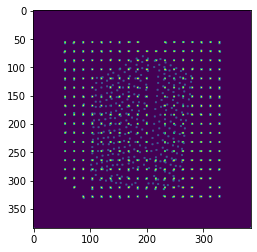

In [10]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.5) Supervised Euclidean for LASTENAS BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [11]:
store_path = 'experiments/7_5_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENAS/test'

path_fixed = r'D:\Julian\data\LASTENAS\fix'
path_train = r'D:\Julian\data\LASTENAS\train'
path_validation = r'D:\Julian\data\LASTENAS\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENAS\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [12]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [13]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [14]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [15]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 420 steps, validate for 90 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

419/420 [============================>.] - ETA: 0s - loss: 1830.2501 - maed: 34.4248WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 76s 182ms/step - loss: 1828.7020 - maed: 34.4070 - val_loss: 1482.7795 - val_maed: 30.9560
Epoch 2/100
419/420 [============================>.] - ETA: 0s - loss: 854.0696 - maed: 22.8905- ETA: 1s - loss: 857.099WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 68s 163ms/step - loss: 853.3646 - maed: 22.8809 - val_loss: 953.2127 - val_maed: 24.8989
Epoch 3/100
419/420 [============================>.] - ETA: 0s - loss: 578.1024 - maed: 18.8115WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 70s 166ms/step - loss: 578.3717 - maed: 18.8185 - val_loss: 709.3965 - val_maed: 21.7137
Epoch 4/100
419/420 [============================>.] - ET

419/420 [============================>.] - ETA: 0s - loss: 34.6119 - maed: 4.6049WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 70s 166ms/step - loss: 34.5900 - maed: 4.6034 - val_loss: 170.7723 - val_maed: 9.3218
Epoch 43/100
419/420 [============================>.] - ETA: 0s - loss: 33.7497 - maed: 4.5433WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 68s 163ms/step - loss: 33.7480 - maed: 4.5429 - val_loss: 160.2376 - val_maed: 8.8200
Epoch 44/100
419/420 [============================>.] - ETA: 0s - loss: 32.2974 - maed: 4.4664WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 69s 164ms/step - loss: 32.2828 - maed: 4.4653 - val_loss: 178.2288 - val_maed: 9.6733
Epoch 45/100
419/420 [============================>.] - ETA: 0s - loss: 32.7632 - maed: 4.4751WARN

Epoch 63/100
419/420 [============================>.] - ETA: 0s - loss: 21.1937 - maed: 3.6186WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 74s 176ms/step - loss: 21.2019 - maed: 3.6196 - val_loss: 147.9334 - val_maed: 8.2937
Epoch 64/100
419/420 [============================>.] - ETA: 0s - loss: 17.3273 - maed: 3.2666- ETA: 2s - WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 71s 170ms/step - loss: 17.3403 - maed: 3.2678 - val_loss: 168.0308 - val_maed: 9.0740
Epoch 65/100
419/420 [============================>.] - ETA: 0s - loss: 19.3639 - maed: 3.4589WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 70s 166ms/step - loss: 19.3564 - maed: 3.4586 - val_loss: 165.3427 - val_maed: 8.9638
Epoch 66/100
419/420 [============================>.] - ETA: 0s - loss: 1

Epoch 84/100
419/420 [============================>.] - ETA: 0s - loss: 13.5362 - maed: 2.8858- ETA: 0s - loss: 13.5212 - maed: 2.885WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 74s 176ms/step - loss: 13.5281 - maed: 2.8850 - val_loss: 145.9223 - val_maed: 8.0817
Epoch 85/100
419/420 [============================>.] - ETA: 0s - loss: 13.3358 - maed: 2.8647WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 74s 176ms/step - loss: 13.3399 - maed: 2.8647 - val_loss: 149.1940 - val_maed: 8.0664
Epoch 86/100
419/420 [============================>.] - ETA: 0s - loss: 11.7296 - maed: 2.6932WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
420/420 [==============================] - 71s 169ms/step - loss: 11.7340 - maed: 2.6936 - val_loss: 149.7343 - val_maed: 8.1590
Epoch 87/100
419/420 [========================

# Evaluation
Evaluate the trained network

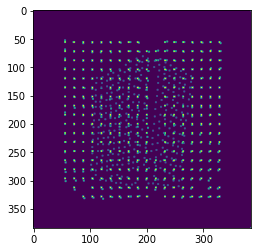

In [16]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.6) Supervised Euclidean for LASTENS+LASTEN BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

In [4]:
tf.keras.backend.clear_session()

# Data
Import training images

In [5]:
store_path = 'experiments/7_6_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS_LASTEN/test'

path_fixed = r'D:\Julian\data\LASTENS_LASTEN\fix'
path_train = r'D:\Julian\data\LASTENS_LASTEN\train'
path_validation = r'D:\Julian\data\LASTENS_LASTEN\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENS_LASTEN\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [7]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [8]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5", period=10)
checker_best = ModelCheckpoint(store_path + "/best_weights.hdf5", save_best_only=True)
callbacks = [timelogger, logger, checker, checker_best, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [9]:
model.load_weights(store_path + "/weights.80.hdf5")
model.fit(train_gen,
          epochs=100,
          initial_epoch=81,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 882 steps, validate for 189 steps
Epoch 82/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

881/882 [============================>.] - ETA: 0s - loss: 4.8306 - maed: 1.5165WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
882/882 [==============================] - 144s 163ms/step - loss: 4.8311 - maed: 1.5165 - val_loss: 93.6239 - val_maed: 4.9094
Epoch 83/100
881/882 [============================>.] - ETA: 0s - loss: 4.5912 - maed: 1.4597WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
882/882 [==============================] - 129s 147ms/step - loss: 4.5905 - maed: 1.4596 - val_loss: 90.9458 - val_maed: 4.9171
Epoch 84/100
881/882 [============================>.] - ETA: 0s - loss: 4.5749 - maed: 1.4483WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
882/882 [==============================] - 128s 145ms/step - loss: 4.5716 - maed: 1.4478 - val_loss: 85.5571 - val_maed: 4.3427
Epoch 85/100
881/882 [============================>.] - ETA: 0s - loss: 4.0312 - maed: 1.3887WARNING:ten

# Evaluation
Evaluate the trained network

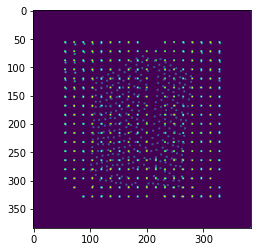

In [10]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)